# Test Algorithm 1 on MNIST dataset

In [1]:
#!rm -rf code
#!git clone https://xxxx/yyyy.git code
#!mv code/* .
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_datasets import *
import pandas as pd
import seaborn as sns
import pickle
from IPython.display import clear_output
import matplotlib
from scipy.optimize import curve_fit
from derivative_decay import get_metrics, dataset_metrics, show_neurons_1, show_W_profile

Using TensorFlow backend.


Initialized TensorFlow


In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
# pfailure for the first layer
p = 1e-2
np.random.seed(42)

In [4]:
# alpha from the proof
alpha = np.e ** 2.5 * p
assert alpha < 1, "Must have a non-trivial guarantee on weight perturbation"
print("Alpha P3", alpha)

# TARGET desired probability of failure
delta_target = 1e-5

# TARGET loss perturbation (will guarantee it happens with prob. at most delta_target)
eps_target = 0.009

print("Will guarantee eps=%.2f delta=%.6f" % (eps_target, delta_target))

Alpha P3 0.12182493960703472
Will guarantee eps=0.01 delta=0.000010


In [5]:
def get_exp(N = 50, mu = 1, lambda_ = 0.0, psi_d = 0, psi_s = 0, nu = 0, epochs = 30, do_print = 'plot'):
    """ Train a network with given size N and compute mean FT variance
         Returns: dict mean -> mean error on example, std -> std error on example, q -- q factor
    """
    K.clear_session()
    
    # run with random weights and multiple inputs
    exp = MNISTExperiment(N = [N, 100], p_inference = [0, p, 0, 0], seed = int(np.random.random() * 100000),
                                  activation = 'sigmoid', epochs = epochs, do_print = do_print, batch_size = 1000,
                                  reg_spec = {'balanced': mu,
                                              'vardelta': {'p': p, 'lambda': lambda_},
                                              'l1': nu,
                                              'continuous': [psi_d, psi_s]
                                             })
    
    return exp

In [6]:
# obtaining some experiment for x, y
exp = get_exp(N = 10, epochs = 1, do_print = False)

# obtaining one input
x = exp.x_train[0:1]
y = exp.y_train[0:1]

In [7]:
def q_factor_v(vect):
    """ q = v^min/v^min, see the main paper """
    vect = np.abs(vect)
    assert np.max(vect) > 0, "Cannot compute for vector of zeros """
    return np.min(vect) / np.max(vect)

def q_factor_l1(exp):
    """ q-factor for layer 1 of an experiment """
    W = exp.W[0]
    
    # here taking sum for 1st axis since it's not transposed here
    q = q_factor_v(np.sum(np.abs(W), axis = 1))
    
    return {'q_1': q}

def d_kl(a, b):
    """ KL-divergence between numbers """
    a, b = float(a), float(b)
    return a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))

def estimate_experimental_error(exp, repetitions = 10000):
    """ Estimate experimental Delta on x, y """
    def experimental_error(exp):
        """ Experimental delta_L+1 on input x, y """
        return exp.get_mse_crash_data(x, y, repetitions = 1) - exp.get_mse_correct_data(x, y)

    # the experimental error
    dta = [experimental_error(exp) for _ in range(repetitions)]
    
    # histogram of experimental error
    plt.hist(dta, label = 'Experimental error')
    plt.axvline(eps_target, label = 'Target threshold', color = 'red')
    plt.legend()
    plt.xlabel('$\Delta$')
    plt.ylabel('Frequency')
    plt.show()
    
    # empirical probability of failure
    delta_empirical = np.mean(np.array(dta) > eps_target)
    
    return {'_exp_error_mse': dta,
           'exp_mse_mean': np.mean(dta),
           'exp_mse_std': np.std(dta),
           'empirical_p': delta_empirical}

def estimate_theoretical_error(exp):
    """ Estimate bound Delta on x, y """
    r = exp._get_bound_b3_loss(x, y)
    return {'bound_mse_mean': r['mean'],
           'bound_mse_std': r['std']}

def continuity(exp):
    """ Compute maximal derivative """
    result_d = []
    result_s = []
    sess = get_session()
    obj = Continuous(1, 1)
    for w in exp.model_correct.weights[0::2]:
        R = sess.run(obj(w, return_dict = True))
        result_d.append(R['derivative'])
        result_s.append(R['smoothness'])
    return {'derivative': result_d[0], 'smoothness': result_s[0]}

In [8]:
# list of things to run
to_run = [dataset_metrics, show_neurons_1, q_factor_l1, estimate_experimental_error, estimate_theoretical_error, continuity, show_W_profile]

In [9]:
# all parameters
parameters = {'N': 1, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-8, 'psi_s': 1e-6}

In [10]:
def inc_n():
    """ Increase the number of neurons """
    global N
    parameters['N'] += 100

Trying parameters {'N': 1, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-08, 'psi_s': 1e-06}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


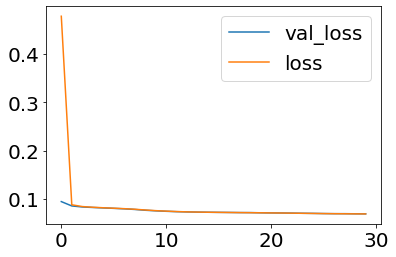

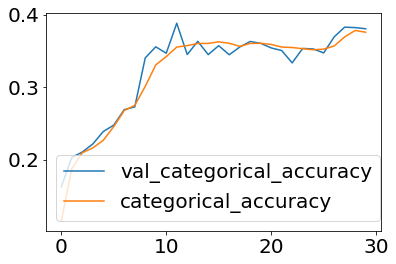

{'val_acc': 0.3804999977350235, 'train_acc': 0.3757000004251798, 'val_loss': 0.06960351392626762, 'train_loss': 0.06944159331421057}


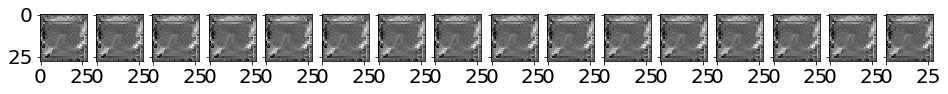

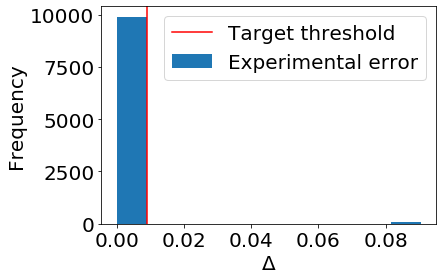

Layer 0


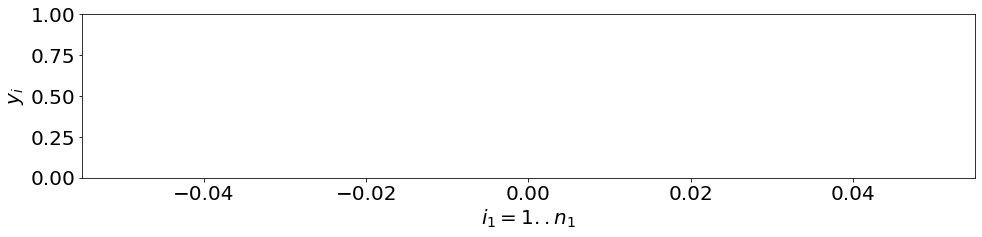

IntDer, Conv {'derivative': 0.0, 'smoothness': 0.0}
Layer 1


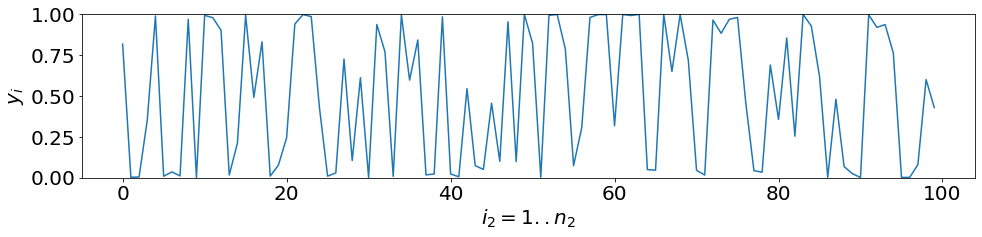

IntDer, Conv {'derivative': 134.22705, 'smoothness': 0.8451047}
Layer 2


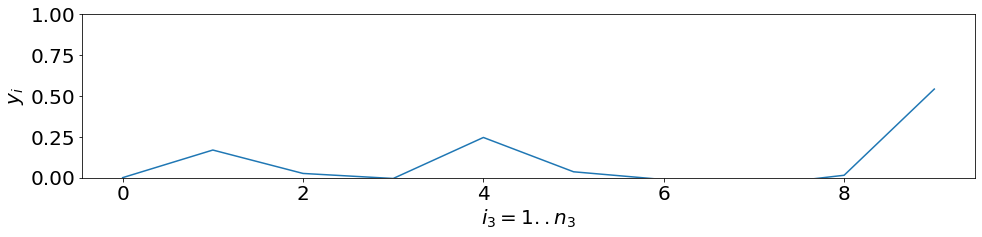

IntDer, Conv {'derivative': 71.407616, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.01
q 1.00 D 0.00 S 0.00
Bound Mean 0.000 Std 0.004
Exp   Mean 0.001 Std 0.009
Perturbation must be small but delta_0=0.819300, consider increasing n
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-08, 'psi_s': 1e-06}


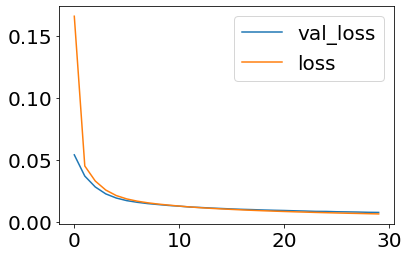

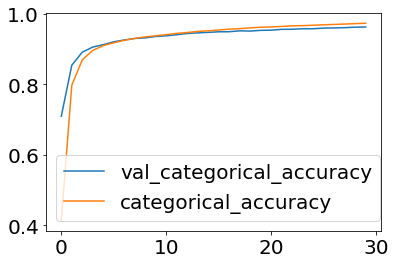

{'val_acc': 0.9625, 'train_acc': 0.9731000006198883, 'val_loss': 0.007541526271961629, 'train_loss': 0.006340132025070488}


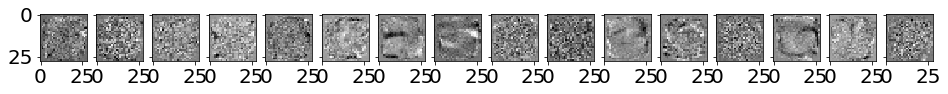

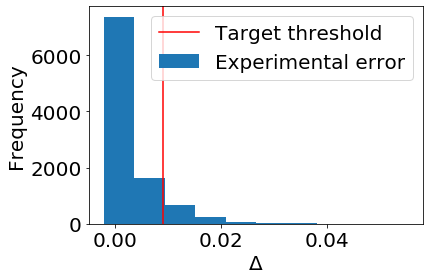

Layer 0


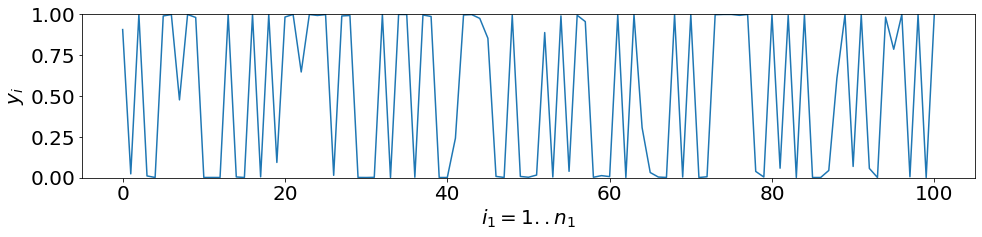

IntDer, Conv {'derivative': 4410.3506, 'smoothness': 26.25806}
Layer 1


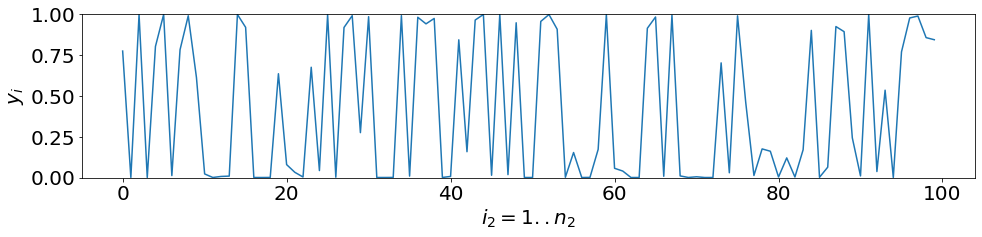

IntDer, Conv {'derivative': 1455.7224, 'smoothness': 8.797097}
Layer 2


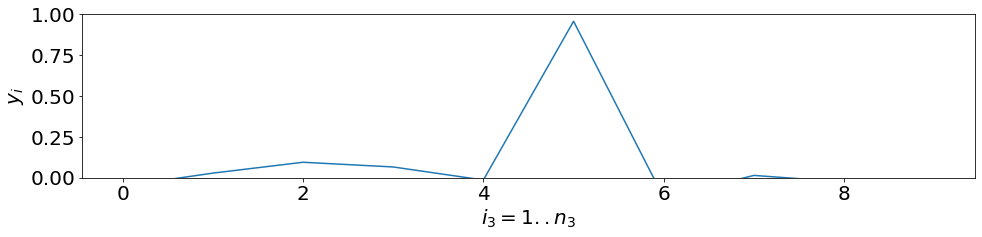

IntDer, Conv {'derivative': 64.07974, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.10
q 0.24 D 4410.35 S 26.26
Bound Mean -0.000 Std 0.002
Exp   Mean 0.003 Std 0.005
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-07, 'psi_s': 9.999999999999999e-06}


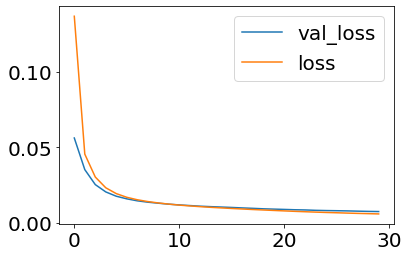

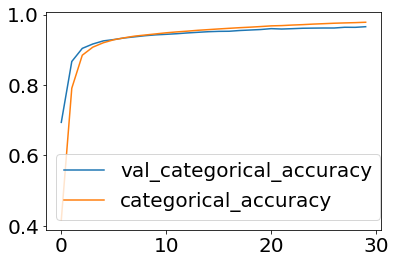

{'val_acc': 0.965499997138977, 'train_acc': 0.978166667620341, 'val_loss': 0.007578090345486998, 'train_loss': 0.0060136675912265975}


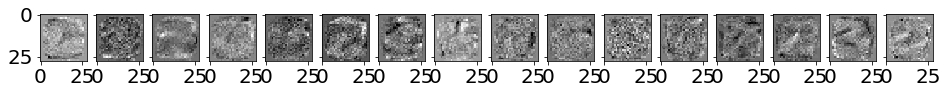

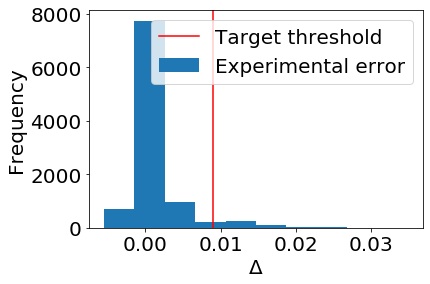

Layer 0


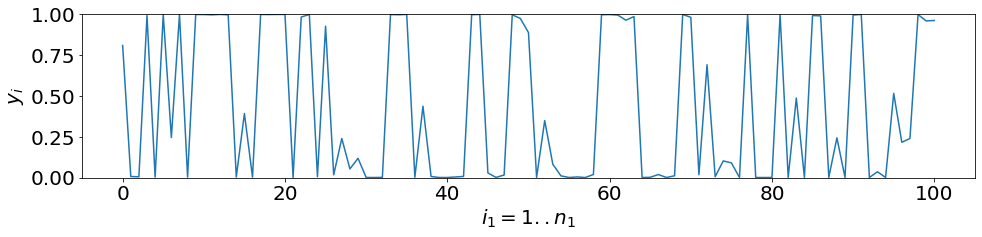

IntDer, Conv {'derivative': 3261.669, 'smoothness': 19.401909}
Layer 1


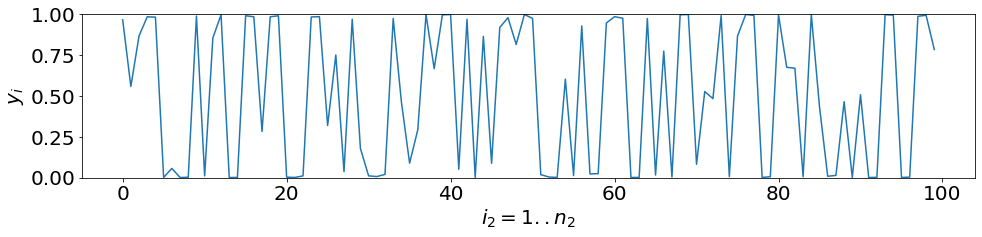

IntDer, Conv {'derivative': 1377.0244, 'smoothness': 8.415061}
Layer 2


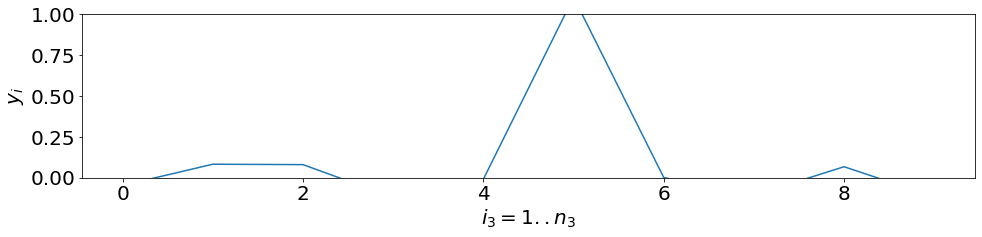

IntDer, Conv {'derivative': 68.435005, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.04
q 0.31 D 3261.67 S 19.40
Bound Mean -0.001 Std 0.002
Exp   Mean 0.001 Std 0.004
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-06, 'psi_s': 9.999999999999999e-05}


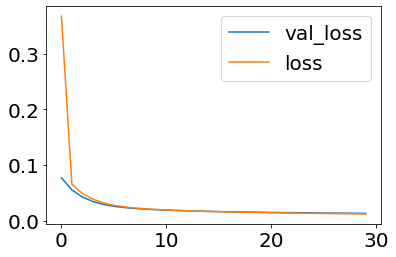

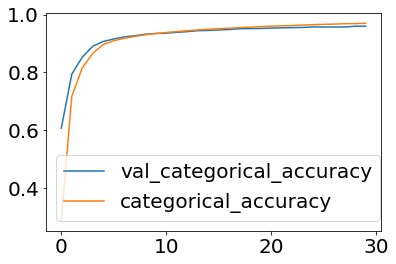

{'val_acc': 0.9603999972343444, 'train_acc': 0.9703833351532618, 'val_loss': 0.012839191872626544, 'train_loss': 0.011850106064230204}


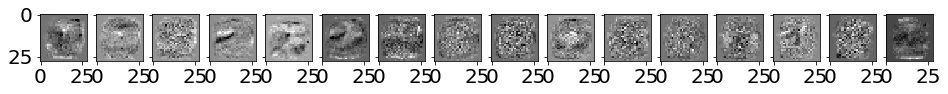

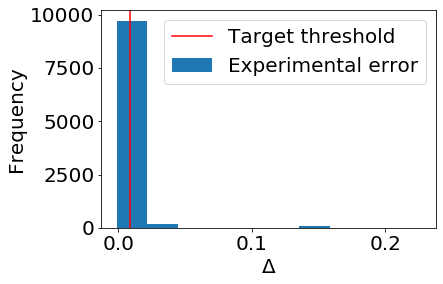

Layer 0


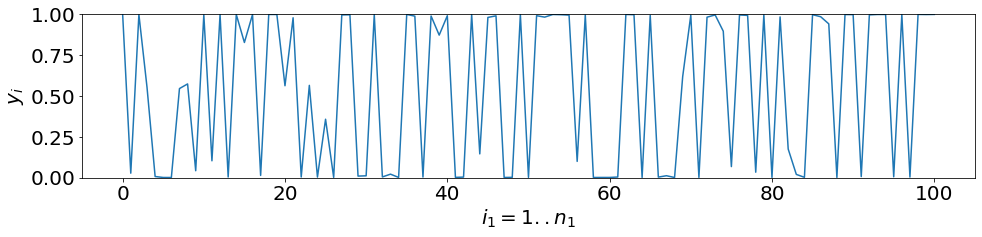

IntDer, Conv {'derivative': 1791.17, 'smoothness': 10.750662}
Layer 1


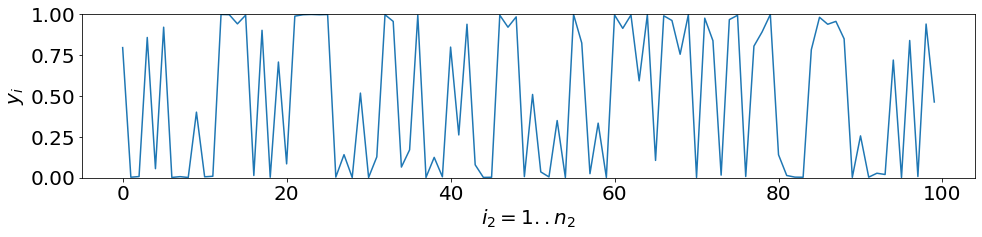

IntDer, Conv {'derivative': 1161.9019, 'smoothness': 6.9817724}
Layer 2


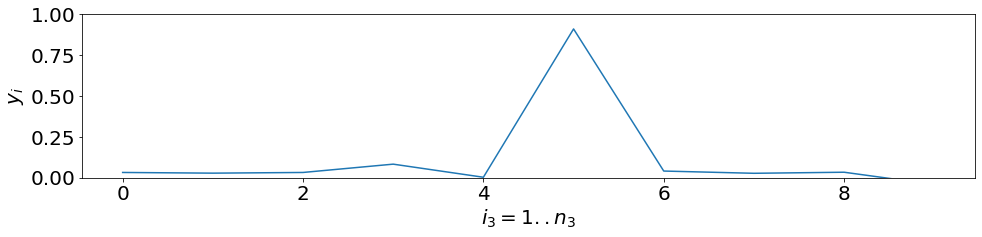

IntDer, Conv {'derivative': 63.898605, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.10
q 0.28 D 1791.17 S 10.75
Bound Mean 0.000 Std 0.002
Exp   Mean 0.004 Std 0.017
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 9.999999999999999e-06, 'psi_s': 0.001}


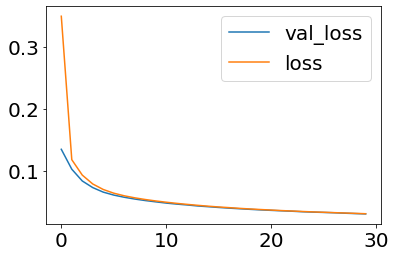

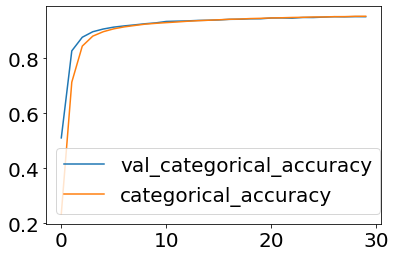

{'val_acc': 0.9512000024318695, 'train_acc': 0.9529499997695287, 'val_loss': 0.030863418802618982, 'train_loss': 0.031182292414208255}


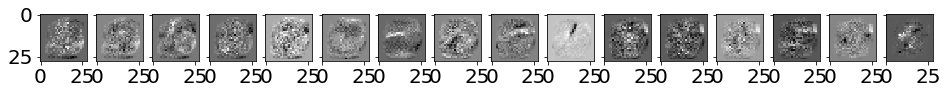

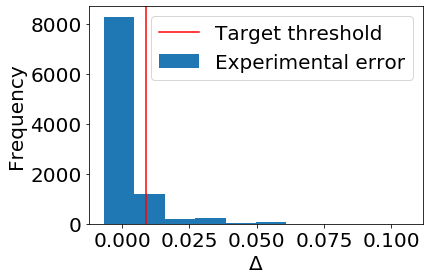

Layer 0


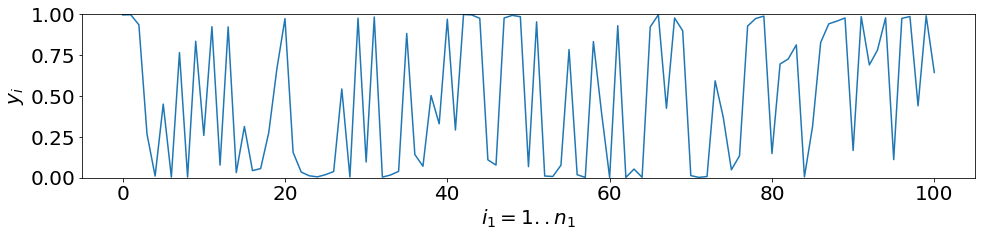

IntDer, Conv {'derivative': 432.42572, 'smoothness': 2.4616284}
Layer 1


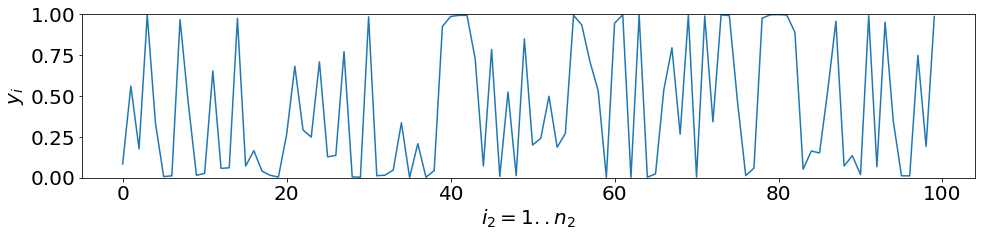

IntDer, Conv {'derivative': 694.4306, 'smoothness': 4.110678}
Layer 2


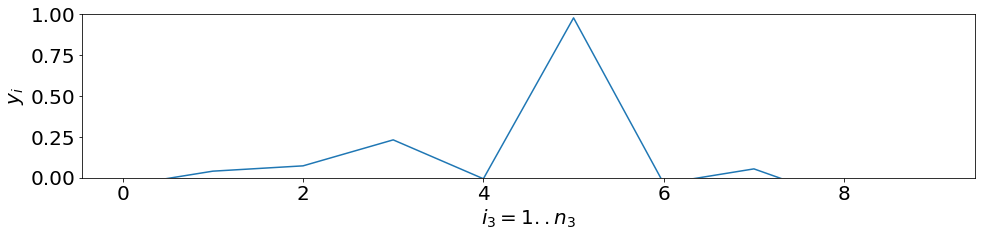

IntDer, Conv {'derivative': 69.16536, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.09
q 0.30 D 432.43 S 2.46
Bound Mean -0.000 Std 0.004
Exp   Mean 0.003 Std 0.009
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


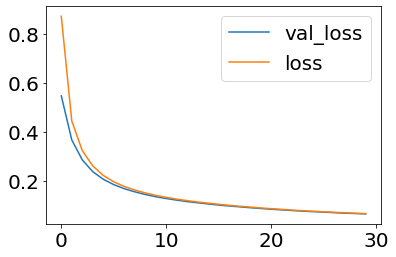

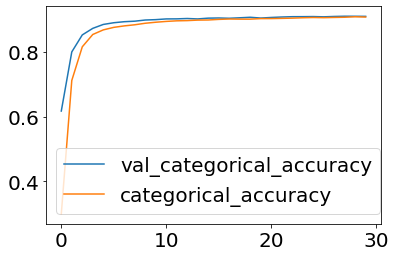

{'val_acc': 0.9104999959468841, 'train_acc': 0.9084000031153361, 'val_loss': 0.06488904729485512, 'train_loss': 0.06618359237909317}


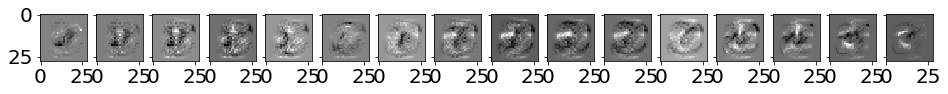

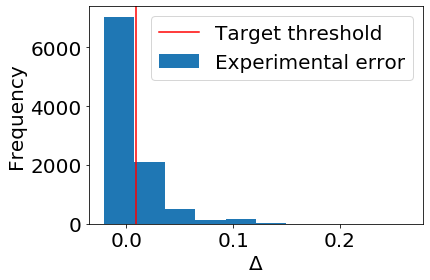

Layer 0


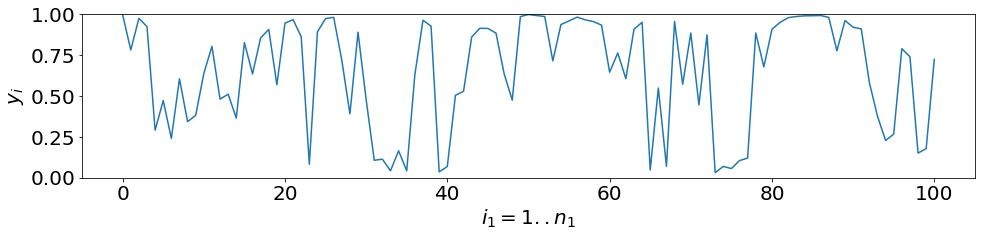

IntDer, Conv {'derivative': 68.06221, 'smoothness': 0.3235236}
Layer 1


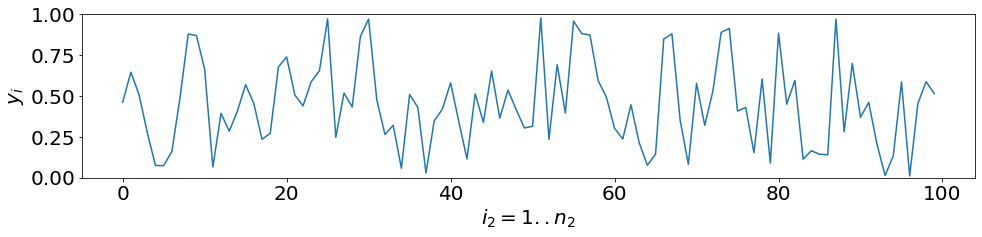

IntDer, Conv {'derivative': 148.74432, 'smoothness': 0.7753657}
Layer 2


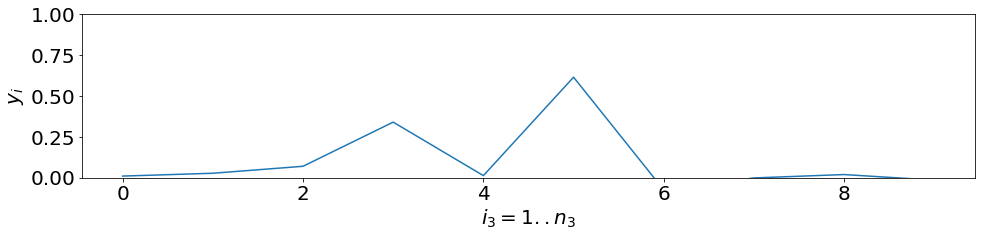

IntDer, Conv {'derivative': 81.068535, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.27
q 0.35 D 68.06 S 0.32
Bound Mean 0.001 Std 0.013
Exp   Mean 0.009 Std 0.022
Must have eps^2 ~ Variance (have 2.37), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 201, 'mu': 1e-10, 'lambda_': 1e-09, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


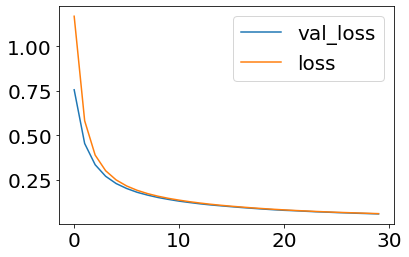

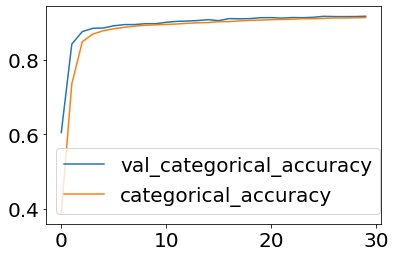

{'val_acc': 0.9164999842643737, 'train_acc': 0.9129333317279815, 'val_loss': 0.05780822336673737, 'train_loss': 0.05934986149271329}


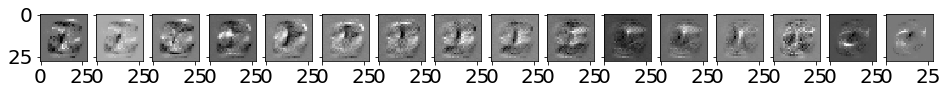

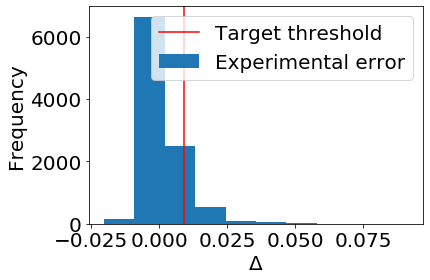

Layer 0


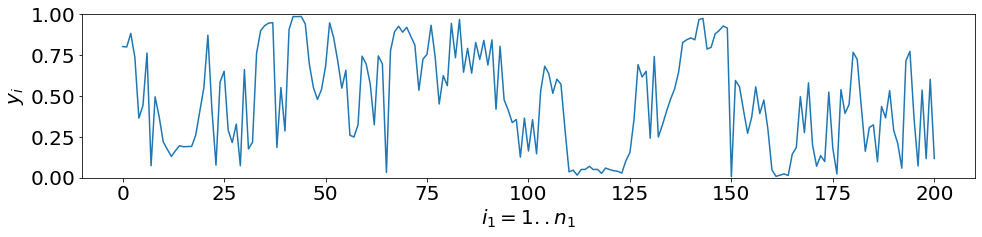

IntDer, Conv {'derivative': 69.694595, 'smoothness': 0.26446933}
Layer 1


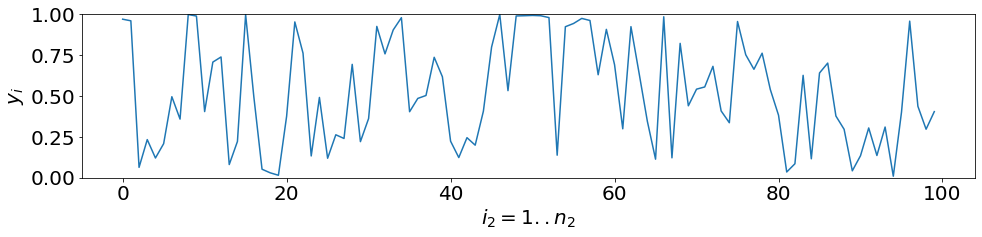

IntDer, Conv {'derivative': 97.36134, 'smoothness': 0.47565275}
Layer 2


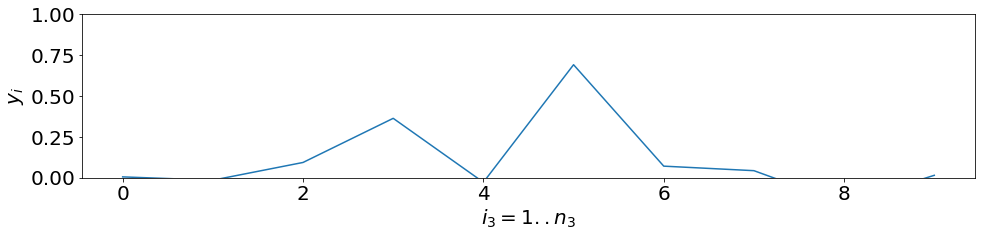

IntDer, Conv {'derivative': 81.79838, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.13
q 0.24 D 69.69 S 0.26
Bound Mean 0.000 Std 0.006
Exp   Mean 0.002 Std 0.007
Must have eps^2 ~ Variance (have 0.46), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 301, 'mu': 1e-10, 'lambda_': 1e-08, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


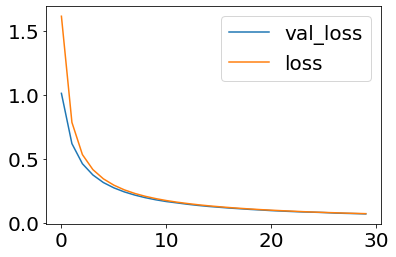

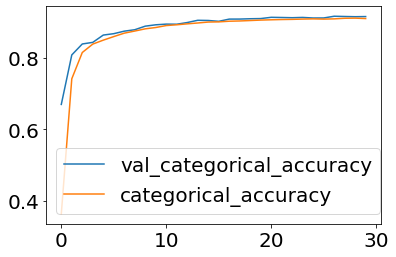

{'val_acc': 0.915200001001358, 'train_acc': 0.9096499999364217, 'val_loss': 0.06872177794575692, 'train_loss': 0.07087087457378706}


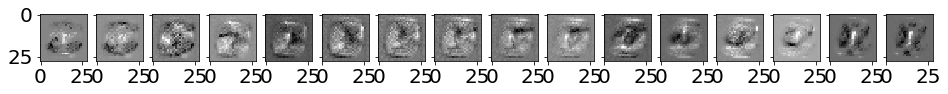

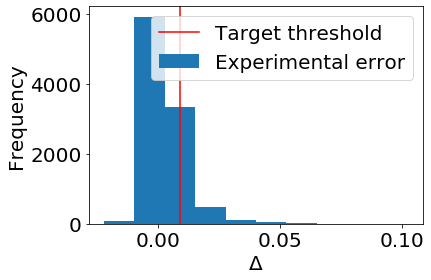

Layer 0


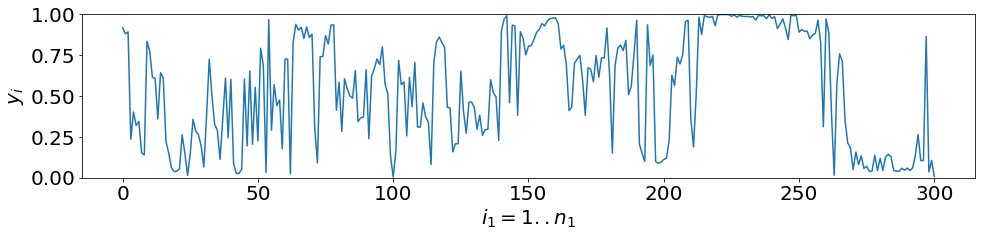

IntDer, Conv {'derivative': 80.77173, 'smoothness': 0.24034713}
Layer 1


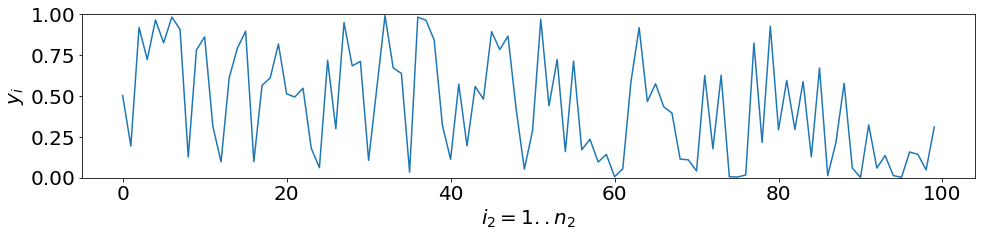

IntDer, Conv {'derivative': 132.10272, 'smoothness': 0.6710251}
Layer 2


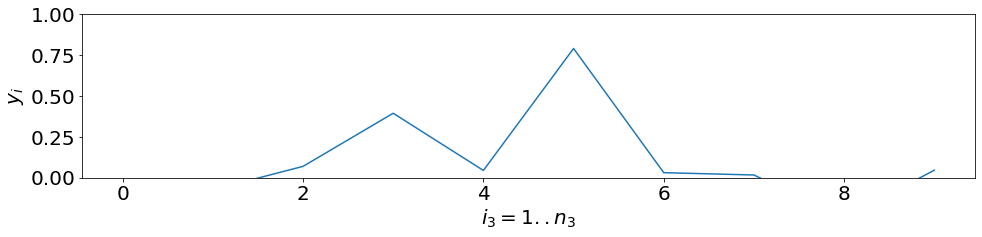

IntDer, Conv {'derivative': 77.62184, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.16
q 0.16 D 80.77 S 0.24
Bound Mean 0.001 Std 0.006
Exp   Mean 0.004 Std 0.008
Must have eps^2 ~ Variance (have 0.53), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 401, 'mu': 1e-10, 'lambda_': 1e-07, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


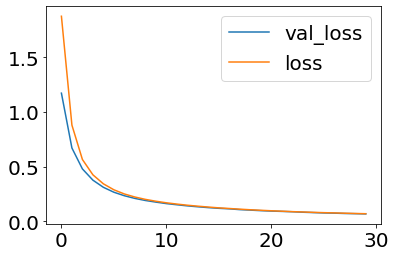

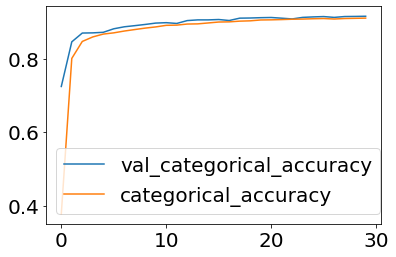

{'val_acc': 0.9149999976158142, 'train_acc': 0.909866667787234, 'val_loss': 0.06815304048359394, 'train_loss': 0.07002896927297116}


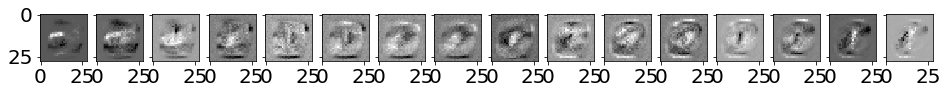

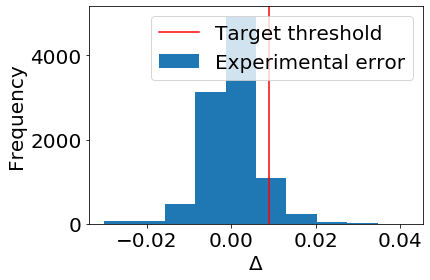

Layer 0


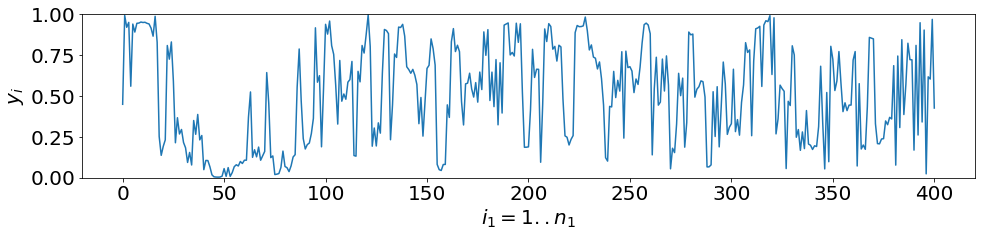

IntDer, Conv {'derivative': 86.244484, 'smoothness': 0.2467764}
Layer 1


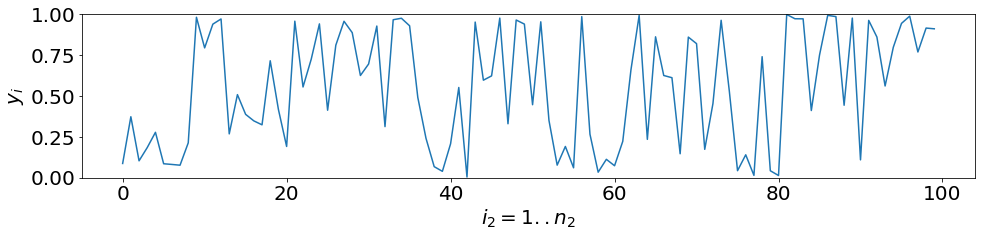

IntDer, Conv {'derivative': 111.788414, 'smoothness': 0.55241156}
Layer 2


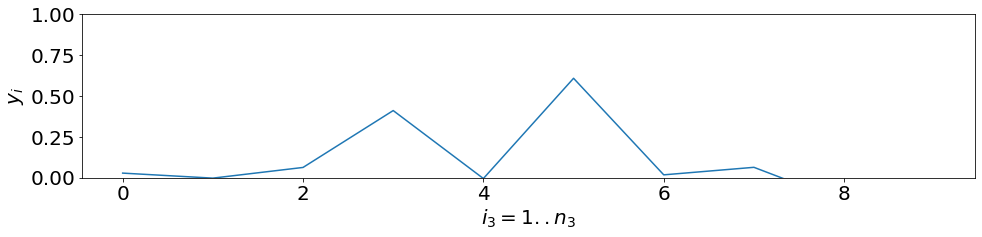

IntDer, Conv {'derivative': 74.95864, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.07
q 0.08 D 86.24 S 0.25
Bound Mean -0.002 Std 0.007
Exp   Mean 0.000 Std 0.006
Must have eps^2 ~ Variance (have 0.38), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 501, 'mu': 1e-10, 'lambda_': 1e-06, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


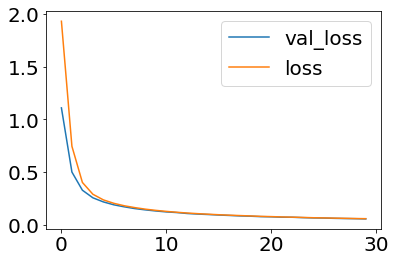

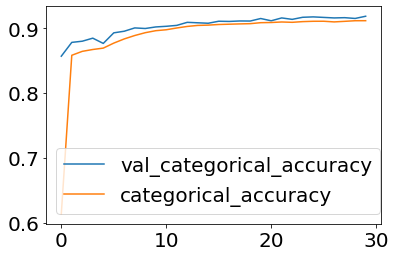

{'val_acc': 0.9186000049114227, 'train_acc': 0.9117333312829335, 'val_loss': 0.057188451290130615, 'train_loss': 0.05946909648676713}


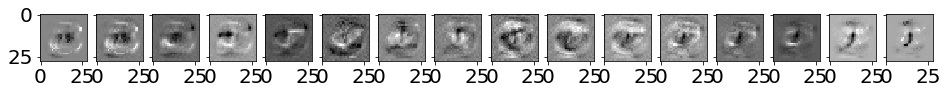

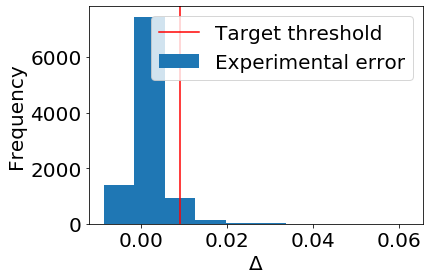

Layer 0


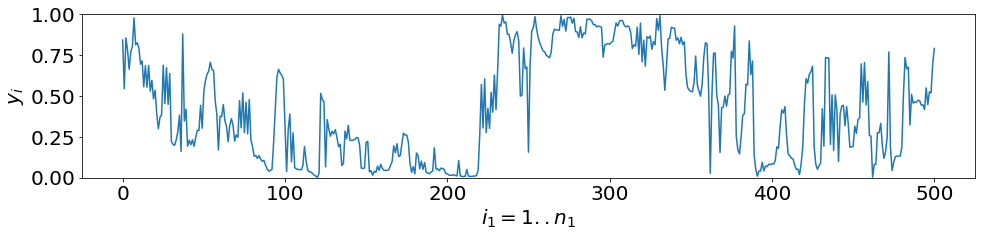

IntDer, Conv {'derivative': 86.82645, 'smoothness': 0.22357292}
Layer 1


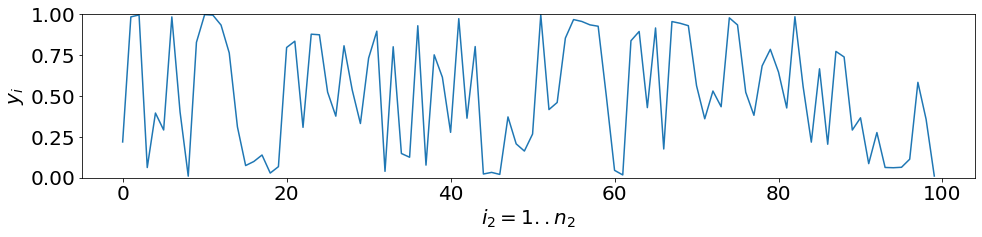

IntDer, Conv {'derivative': 73.709236, 'smoothness': 0.34696168}
Layer 2


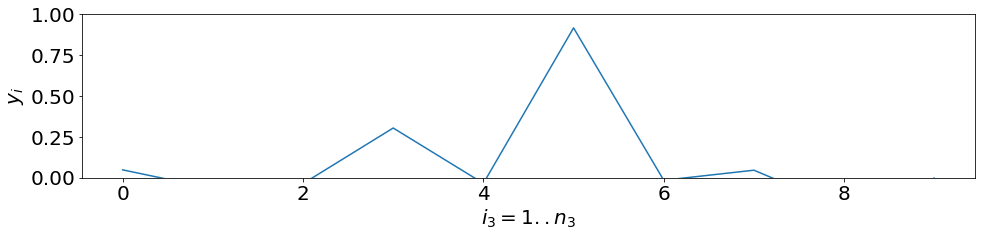

IntDer, Conv {'derivative': 72.05091, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.05
q 0.12 D 86.83 S 0.22
Bound Mean 0.001 Std 0.003
Exp   Mean 0.001 Std 0.004
Need {'N': 501, 'mu': 1e-10, 'lambda_': 1e-06, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}
To achieve eps=0.009000 delta=0.000010 fault tolerance


In [11]:
while True:
    print('Trying parameters %s' % str(parameters))
    exp = get_exp(**parameters)
    
    r = get_metrics(exp, to_run)
    print('P_empirical %.2f' % r['empirical_p'])
    print("q %.2f D %.2f S %.2f" % (r['q_1'], r['derivative'], r['smoothness']))
    print("Bound Mean %.3f Std %.3f" % (r['bound_mse_mean'], r['bound_mse_std']))
    print("Exp   Mean %.3f Std %.3f" % (r['exp_mse_mean'], r['exp_mse_std']))
    
    if r['q_1'] <= 1e-2:
        print("Q must be >0.01, consider increasing mu")
        parameters['mu'] *= 10
        continue
        
    # delta_0 from Prop. 3
    delta_0 = np.exp(-parameters['N'] * d_kl(alpha, p) * r['q_1'])
    if delta_0 > 1. / 6:
        print("Perturbation must be small but delta_0=%f, consider increasing n" % delta_0)
        inc_n()
        continue
        
    if r['derivative'] >= 100:
        print("Derivative must be < 100, consider increasing psi")
        parameters['psi_d'] *= 10
        parameters['psi_s'] *= 10
        continue
        
    if r['bound_mse_mean'] >= eps_target:
        print("Cannot do better than the mean, infeasible!")
        break
        
    # t from Prop. 5
    # sum to make it a scalar
    t = np.sum(eps_target - r['bound_mse_mean'])
    
    p_have = t ** (-2) * r['bound_mse_std'] ** 2
    if p_have >= 1. / 3:
        print("Must have eps^2 ~ Variance (have %.2f), otherwise Chebyshev would not work!, increasing n and lambda..." % p_have)
        parameters['lambda_'] *= 10
        inc_n()
        continue
        
    # now we have delta_0 < 1/6 and delta-delta_0 < 1 / 6 which makes delta < 1/3
    
    # computing the number of repetitions
    # (1/3)^(R/2)<delta_target -> delta_target => R = 2 log (1 / delta_target) / log(3)
    R = 2 * np.log(1 / delta_target) / np.log(3)
    
    print('Need %s' % str(parameters))
    print('To achieve eps=%f delta=%f fault tolerance' % (eps_target, delta_target))
    
    break

Empirically validating that $\delta<1/3$

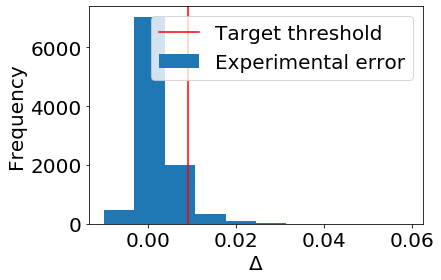

In [12]:
# taking the net
exp = get_exp(**parameters, do_print = False)
r = estimate_experimental_error(exp)

In [13]:
print('Empirical probability: %.2f' % r['empirical_p'])
assert r['empirical_p'] < 1. / 3, "Tail bound must be valid"
print("If no errors, the test has passed successfully")

Empirical probability: 0.07
If no errors, the test has passed successfully


In [14]:
print('Final parameters: %s' % str(parameters))
print('Need %d repetitions of the network with median aggregation' % R)

Final parameters: {'N': 501, 'mu': 1e-10, 'lambda_': 1e-06, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}
Need 20 repetitions of the network with median aggregation
